## Movie Sentiment Analysis

## Preprocessing Data

In [2]:
import pandas as pd

In [6]:
df = pd.read_csv("../data/sentiment-analysis-on-movie-reviews/train.tsv", sep="\t")

In [7]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [8]:
df.drop_duplicates(subset=["SentenceId"], inplace=True, keep="first")

Dataset Description
The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
test.tsv contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

<Axes: xlabel='Sentiment'>

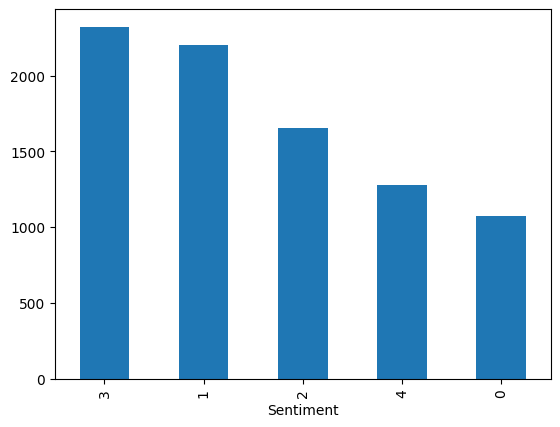

In [11]:
df['Sentiment'].value_counts().plot(kind='bar')

In [49]:
seq_len = 512
num_samples = len(df)


In [50]:
num_samples, seq_len

(8529, 512)

## Tokenizing the data

In [18]:
from transformers import AutoTokenizer

In [51]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokens = tokenizer(df['Phrase'].tolist(), padding='max_length', truncation=True, max_length=seq_len, add_special_tokens=True, return_tensors="np")

In [52]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [53]:
tokens['input_ids'].shape, tokens['attention_mask'].shape

((8529, 512), (8529, 512))

In [54]:
tokens['input_ids']

array([[ 101,  138, 1326, ...,    0,    0,    0],
       [ 101, 1188, 3589, ...,    0,    0,    0],
       [ 101, 2431, 3899, ...,    0,    0,    0],
       ...,
       [ 101,  118,  149, ...,    0,    0,    0],
       [ 101, 1109, 2523, ...,    0,    0,    0],
       [ 101, 1109, 1273, ...,    0,    0,    0]])

In [55]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [58]:
import numpy as np
with open('../data/movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('../data/movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [77]:
## One-hot encode the labels
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
labels = enc.fit_transform(df['Sentiment'].values.reshape(-1, 1))

c:\Users\Abhilash\anaconda3\envs\nlp\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [78]:
labels.shape

(8529, 5)

In [79]:
labels[1]

array([0., 0., 0., 0., 1.])

In [80]:
type(labels)

numpy.ndarray

In [81]:
with open('../data/movie-labels.npy', 'wb') as f:
    np.save(f, labels)

## Building dataset

In [82]:
with open('../data/movie-labels.npy', 'rb') as f:
    labels = np.load(f)

with open('../data/movie-xids.npy', 'rb') as f:
    xids = np.load(f)

with open('../data/movie-xmask.npy', 'rb') as f:
    xmask = np.load(f)        

In [84]:
xids.shape, xmask.shape, labels.shape

((8529, 512), (8529, 512), (8529, 5))

In [85]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((xids, xmask, labels))

In [86]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [89]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [90]:
dataset = dataset.map(map_func)

In [91]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [92]:
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [93]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [94]:
split = 0.9

In [95]:
(train_data, val_data) = dataset.take(int(split*num_samples)), dataset.skip(int(split*num_samples))

In [96]:
train_data.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

## Build the model

In [97]:
from transformers import TFAutoModel

In [98]:
bert = TFAutoModel.from_pretrained("bert-base-cased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [99]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
import tensorflow as tf

In [101]:
# two inputs
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# bert layer
embeddings = bert.bert(input_ids, attention_mask=mask)[1]

# classifier
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)




In [102]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=[y])

In [103]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [104]:
model.layers[2].trainable = False

In [105]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [107]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [108]:
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [109]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [110]:
histry = model.fit(train_data, epochs=3, validation_data=val_data)

Epoch 1/3
 11/533 [..............................] - ETA: 3:08:55 - loss: 1.6104 - accuracy: 0.2500

KeyboardInterrupt: 

In [ ]:
model.save('sentiment_model')